# Random Oversampler

In [1]:
import datetime, warnings, scipy
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-whitegrid')
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
from scipy import stats
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

import os
# Storing
import joblib

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import SGDRegressor


# Performance Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pointbiserialr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

# Imbalanced Dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


pd.options.display.float_format = '{:.0f}'.format

In [2]:
from pathlib import Path
data_path=Path('http://localhost:8888/tree/TFM')
dataset=pd.read_csv('flights.csv',low_memory=False)
dataset.head()
dataset.shape

(5819079, 31)

In [3]:
# Missing Values set to 0
dataset['WEATHER_DELAY'] = dataset['WEATHER_DELAY'].fillna(0)
dataset['LATE_AIRCRAFT_DELAY'] = dataset['LATE_AIRCRAFT_DELAY'].fillna(0)
dataset['AIRLINE_DELAY'] = dataset['AIRLINE_DELAY'].fillna(0)
dataset['SECURITY_DELAY'] = dataset['SECURITY_DELAY'].fillna(0)
dataset['AIR_SYSTEM_DELAY'] = dataset['AIR_SYSTEM_DELAY'].fillna(0)

In [4]:
# Drop Columns
dataset.drop(['YEAR','FLIGHT_NUMBER','TAIL_NUMBER','DIVERTED','CANCELLED','CANCELLATION_REASON','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY','SCHEDULED_TIME','DISTANCE'],
                 axis = 1, inplace = True)

In [5]:
dataset = dataset.dropna()

In [6]:
# Date Transformation
import calendar

# 1 = Weekday, 0 = Weekend
Day_Week_Type = []
for value in dataset['DAY_OF_WEEK']:
    if value in (0,1,2,3,4):
        Day_Week_Type.append(1) # Weekday
    else:
        Day_Week_Type.append(0) # Weekend
dataset['WEEKDAY_TYPE'] = Day_Week_Type
dataset.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEEKDAY_TYPE
0,1,1,4,AS,ANC,SEA,5,2354,-11,21,15,194,169,404,4,430,408,-22,1
1,1,1,4,AA,LAX,PBI,10,2,-8,12,14,279,263,737,4,750,741,-9,1
2,1,1,4,US,SFO,CLT,20,18,-2,16,34,293,266,800,11,806,811,5,1
3,1,1,4,AA,LAX,MIA,20,15,-5,15,30,281,258,748,8,805,756,-9,1
4,1,1,4,AS,SEA,ANC,25,24,-1,11,35,215,199,254,5,320,259,-21,1


In [7]:
from sklearn import preprocessing
Label_Encoder = preprocessing.LabelEncoder()
dataset['AIRLINE'] = Label_Encoder.fit_transform(dataset['AIRLINE'])
dataset['ORIGIN_AIRPORT'] = Label_Encoder.fit_transform(dataset['ORIGIN_AIRPORT'])
dataset['DESTINATION_AIRPORT'] = Label_Encoder.fit_transform(dataset['DESTINATION_AIRPORT'])
dataset.dtypes

MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                  int32
ORIGIN_AIRPORT           int32
DESTINATION_AIRPORT      int32
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
ELAPSED_TIME           float64
AIR_TIME               float64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
WEEKDAY_TYPE             int64
dtype: object

## Target Attribute: Flight Status
FLIGHT_STATUS determines whether the flight arrives on time (ARRIVAL_DELAY <= 15min) or it is delayed (ARRIVAL_DELAY > 15min). FLIGHT_STATUS value is 0 if flights arrive early or on time and 1 for flights that are delayed.

In [8]:
Status = []

for Value in dataset['ARRIVAL_DELAY']:
    if Value <= 15:
        Status.append(0)
    else:
        Status.append(1)
dataset['FLIGHT_STATUS'] = Status
dataset.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEEKDAY_TYPE,FLIGHT_STATUS
0,1,1,4,1,323,584,5,2354,-11,21,15,194,169,404,4,430,408,-22,1,0
1,1,1,4,0,482,542,10,2,-8,12,14,279,263,737,4,750,741,-9,1,0
2,1,1,4,11,584,373,20,18,-2,16,34,293,266,800,11,806,811,5,1,0
3,1,1,4,0,482,510,20,15,-5,15,30,281,258,748,8,805,756,-9,1,0
4,1,1,4,1,583,324,25,24,-1,11,35,215,199,254,5,320,259,-21,1,0


## Dataset Splitting for Training and Testing

In [9]:
Labels = dataset[["FLIGHT_STATUS", "ARRIVAL_DELAY"]]
Features = dataset.drop(columns = ['SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'FLIGHT_STATUS', 'ARRIVAL_DELAY'])
print(f"\nDataset Shape: {dataset.shape}")
dataset.head()


Dataset Shape: (5714008, 20)


,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,WEEKDAY_TYPE,FLIGHT_STATUS
0,1,1,4,1,323,584,5,2354,-11,21,15,194,169,404,4,430,408,-22,1,0
1,1,1,4,0,482,542,10,2,-8,12,14,279,263,737,4,750,741,-9,1,0
2,1,1,4,11,584,373,20,18,-2,16,34,293,266,800,11,806,811,5,1,0
3,1,1,4,0,482,510,20,15,-5,15,30,281,258,748,8,805,756,-9,1,0
4,1,1,4,1,583,324,25,24,-1,11,35,215,199,254,5,320,259,-21,1,0


In [10]:
Features_Train, Features_Test, Labels_Train, Labels_Test = train_test_split(Features, Labels, test_size=0.20, train_size=0.8, random_state=42)
del Features
del Labels

## Classification

### Modeling Classifiers - Random Oversampler
For the predictor variable y (Dependent Variable), the necessary features for Classification and Prediction are chosen and are the following: FLIGHT_STATUS and ARRIVAL_DELAY. For X, the Independent Variable, the features related to time and arrival are dropped, because they leak information about the target variable (FLIGHT_STATUS). This features are the following: SCHEDULED_ARRIVAL, ARRIVAL_TIME and ARRIVAL_DELAY.

FLIGHT_STATUS is set as the dependent variable. For the independent variable, all the features are used except for ARRIVAL_DELAY, FLIGHT_STATUS, SCHEDULED_ARRIVAL and ARRIVAL_TIME.

Furthermore, prediction features, FLIGHT_STATUS and ARRIVAL_DELAY (selected features for the Dependent Variable, y) are also dropped.

### Filtering for Classification Training and Testing

In [11]:
# Filtering Data for Classification Training and Testing
Classification_Features_Train, Classification_Features_Test = Features_Train, Features_Test
Classification_Labels_Train, Classification_Labels_Test = Labels_Train["FLIGHT_STATUS"], Labels_Test["FLIGHT_STATUS"]

### Training Data previous to Handling Imbalance

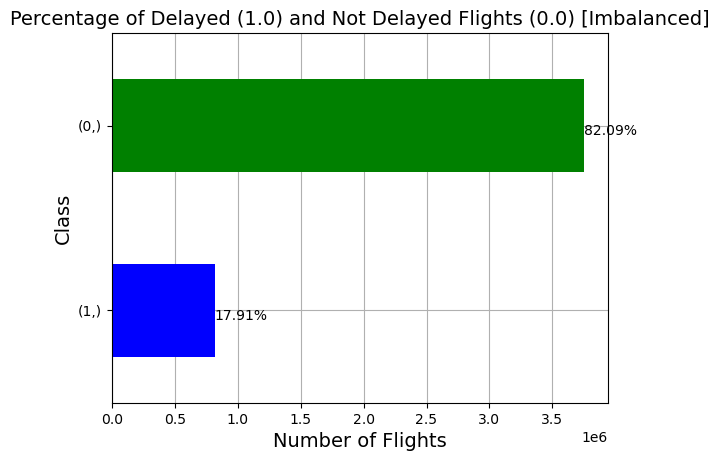

0    4690510
1    1023498
Name: FLIGHT_STATUS, dtype: int64


In [12]:
# Percentage of flights that are Delayed (1.0) and Not Delayed (0.0)
ax = pd.DataFrame(Classification_Labels_Train).value_counts().sort_values().plot(kind="barh", color=["b", "g"])
ax.set_axisbelow(True)
ax.grid()
Totals= []
for i in ax.patches:
    Totals.append(i.get_width())
Total = sum(Totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/Total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("Percentage of Delayed (1.0) and Not Delayed Flights (0.0) [Imbalanced]", fontsize=14)
plt.xlabel("Number of Flights", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(dataset["FLIGHT_STATUS"].value_counts())
fig = ax.get_figure()

## Sampled Data: Random Oversampling

In [13]:
ROS = RandomOverSampler(random_state=42)
Classification_Features_Train, Classification_Labels_Train = ROS.fit_resample(Classification_Features_Train, Classification_Labels_Train)

### Balanced Training Data - Random Oversampling

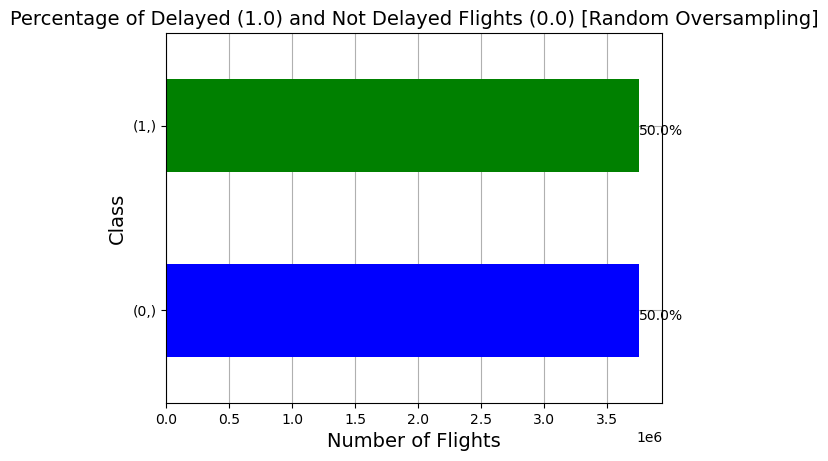

FLIGHT_STATUS
0                3752502
1                3752502
dtype: int64


In [14]:
# Percentage of flights that are Delayed (1.0) and Not Delayed (0.0): Sampled Data - SMOTE
ax = pd.DataFrame(Classification_Labels_Train).value_counts().sort_values().plot(kind="barh", color=["b", "g"])
ax.set_axisbelow(True)
ax.grid()
Totals= []
for i in ax.patches:
    Totals.append(i.get_width())
Total = sum(Totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/Total)*100, 2))+'%', 
     fontsize=10, color='black')
plt.title("Percentage of Delayed (1.0) and Not Delayed Flights (0.0) [Random Oversampling]", fontsize=14)
plt.xlabel("Number of Flights", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.show()
print(pd.DataFrame(Classification_Labels_Train).value_counts())
fig = ax.get_figure()

### Logistic Regression - Random Oversampler

              precision    recall  f1-score   support

           0       0.98      0.91      0.94    938008
           1       0.70      0.90      0.79    204794

    accuracy                           0.91   1142802
   macro avg       0.84      0.91      0.86   1142802
weighted avg       0.93      0.91      0.92   1142802

Balanced Accuracy (Test Set): 0.907
F1-Score (Test Set): 0.785



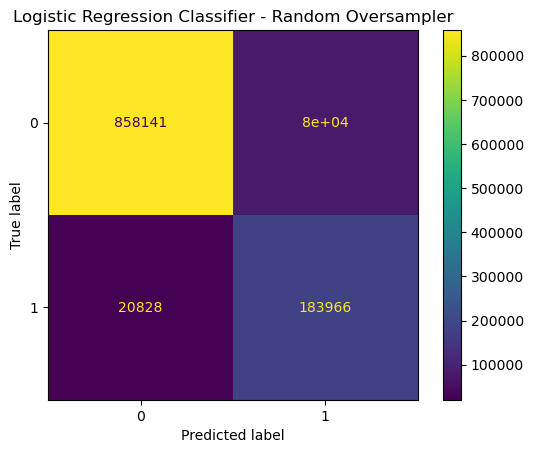

In [15]:
Model = LogisticRegression(n_jobs=-1)
Model.fit(Classification_Features_Train, Classification_Labels_Train)
FileName = 'LogisticRegression_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('LogisticRegression_RandomOversampler.joblib')
Model_Pred = Model.predict(Classification_Features_Test)
# print(confusion_matrix(Classification_Labels_Test, Model_Pred))
print(classification_report(Classification_Labels_Test, Model_Pred))
print(f"Balanced Accuracy (Test Set): {round(balanced_accuracy_score(Classification_Labels_Test, Model_Pred), 3)}")
print(f"F1-Score (Test Set): {round(f1_score(Classification_Labels_Test, Model_Pred), 3)}\n")

Confusion_Matrix = plot_confusion_matrix(Model, Classification_Features_Test, Classification_Labels_Test)
plt.title("Logistic Regression Classifier - Random Oversampler")
print(Confusion_Matrix)
#del Model
#del Model_Pred

### Decision Tree Classifier - Random Oversampler

              precision    recall  f1-score   support

           0       0.96      0.96      0.96    938008
           1       0.81      0.80      0.80    204794

    accuracy                           0.93   1142802
   macro avg       0.88      0.88      0.88   1142802
weighted avg       0.93      0.93      0.93   1142802

Balanced Accuracy (Test Set): 0.878
F1-Score (Test Set): 0.803



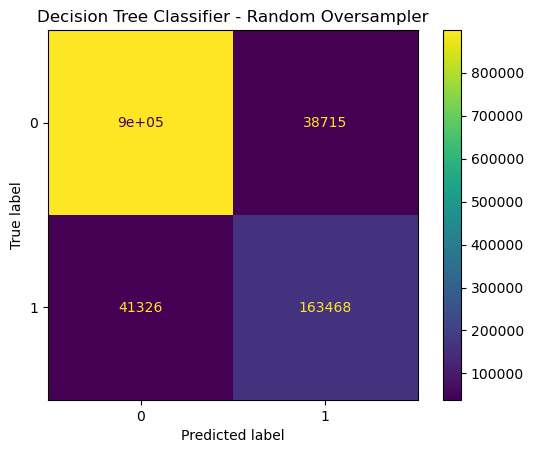

In [16]:
Model = DecisionTreeClassifier()
Model.fit(Classification_Features_Train, Classification_Labels_Train)
FileName = 'DecisionTreeClassifier_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('DecisionTreeClassifier_RandomOversampler.joblib')
Model_Pred = Model.predict(Classification_Features_Test)
# print(confusion_matrix(Classification_Labels_Test, Model_Pred))
print(classification_report(Classification_Labels_Test, Model_Pred))
print(f"Balanced Accuracy (Test Set): {round(balanced_accuracy_score(Classification_Labels_Test, Model_Pred), 3)}")
print(f"F1-Score (Test Set): {round(f1_score(Classification_Labels_Test, Model_Pred), 3)}\n")

Confusion_Matrix = plot_confusion_matrix(Model, Classification_Features_Test, Classification_Labels_Test)
plt.title("Decision Tree Classifier - Random Oversampler")
print(Confusion_Matrix)
#del Model
#del Model_Pred

### Gradient Boosting Classifier - Random Oversampler

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    938008
           1       0.75      0.92      0.82    204794

    accuracy                           0.93   1142802
   macro avg       0.86      0.92      0.89   1142802
weighted avg       0.94      0.93      0.93   1142802

Balanced Accuracy (Test Set): 0.924
F1-Score (Test Set): 0.823



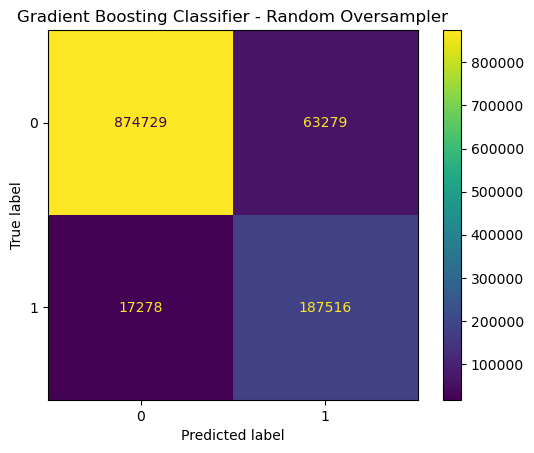

In [17]:
Model = GradientBoostingClassifier()
Model.fit(Classification_Features_Train, Classification_Labels_Train)
FileName = 'GradientBoostingClassifier_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('GradientBoostingClassifier_RandomOversampler.joblib')
Model_Pred = Model.predict(Classification_Features_Test)
# print(confusion_matrix(Classification_Labels_Test, Model_Pred))
print(classification_report(Classification_Labels_Test, Model_Pred))
print(f"Balanced Accuracy (Test Set): {round(balanced_accuracy_score(Classification_Labels_Test, Model_Pred), 3)}")
print(f"F1-Score (Test Set): {round(f1_score(Classification_Labels_Test, Model_Pred), 3)}\n")

Confusion_Matrix = plot_confusion_matrix(Model, Classification_Features_Test, Classification_Labels_Test)
plt.title("Gradient Boosting Classifier - Random Oversampler")
print(Confusion_Matrix)
#del Model
#del Model_Pred

### XGBoost Classifier - Random Oversampler

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    938008
           1       0.77      0.93      0.84    204794

    accuracy                           0.94   1142802
   macro avg       0.88      0.93      0.90   1142802
weighted avg       0.95      0.94      0.94   1142802

Balanced Accuracy (Test Set): 0.935
F1-Score (Test Set): 0.844



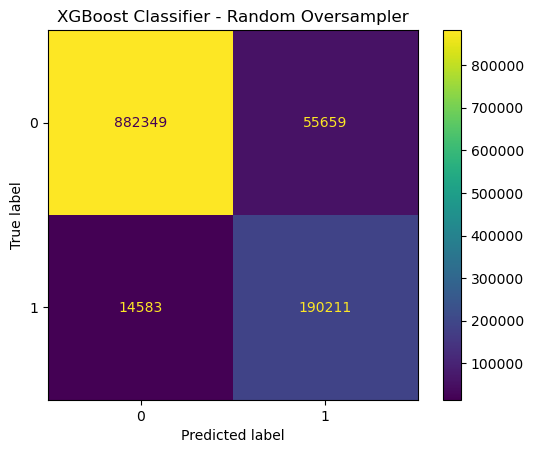

In [18]:
Model = xgb.XGBClassifier()
Model.fit(Classification_Features_Train, Classification_Labels_Train)
FileName = 'XGBClassifier_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('XGBClassifier_RandomOversampler.joblib')
Model_Pred = Model.predict(Classification_Features_Test)
# print(confusion_matrix(Classification_Labels_Test, Model_Pred))
print(classification_report(Classification_Labels_Test, Model_Pred))
print(f"Balanced Accuracy (Test Set): {round(balanced_accuracy_score(Classification_Labels_Test, Model_Pred), 3)}")
print(f"F1-Score (Test Set): {round(f1_score(Classification_Labels_Test, Model_Pred), 3)}\n")

Confusion_Matrix = plot_confusion_matrix(Model, Classification_Features_Test, Classification_Labels_Test)
plt.title("XGBoost Classifier - Random Oversampler")
print(Confusion_Matrix)
#del Model
#del Model_Pred

### Random Forest Classifier - Random Oversampler

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    938008
           1       0.89      0.85      0.87    204794

    accuracy                           0.96   1142802
   macro avg       0.93      0.91      0.92   1142802
weighted avg       0.95      0.96      0.95   1142802

Balanced Accuracy (Test Set): 0.915
F1-Score (Test Set): 0.872



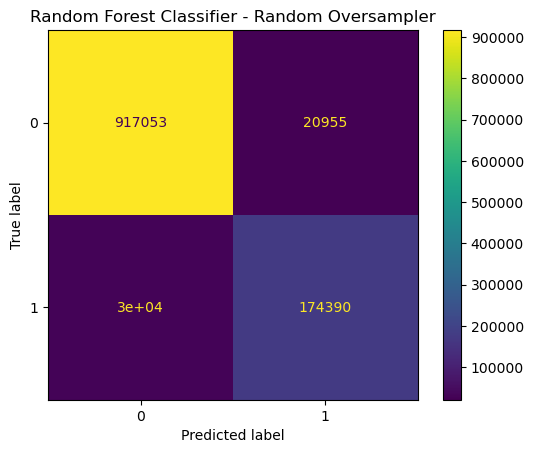

In [19]:
Model = RandomForestClassifier(n_jobs=-1)
Model.fit(Classification_Features_Train, Classification_Labels_Train)
FileName = 'RandomForestClassifier_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('RandomForestClassifier_RandomOversampler.joblib')
Model_Pred = Model.predict(Classification_Features_Test)
# print(confusion_matrix(Classification_Labels_Test, Model_Pred))
print(classification_report(Classification_Labels_Test, Model_Pred))
print(f"Balanced Accuracy (Test Set): {round(balanced_accuracy_score(Classification_Labels_Test, Model_Pred), 3)}")
print(f"F1-Score (Test Set): {round(f1_score(Classification_Labels_Test, Model_Pred), 3)}\n")

Confusion_Matrix = plot_confusion_matrix(Model, Classification_Features_Test, Classification_Labels_Test)
plt.title("Random Forest Classifier - Random Oversampler")
print(Confusion_Matrix)
#del Model
#del Model_Pred

### Extra Trees Classifier - Random Oversampler

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    938008
           1       0.94      0.80      0.86    204794

    accuracy                           0.95   1142802
   macro avg       0.95      0.89      0.92   1142802
weighted avg       0.95      0.95      0.95   1142802

Balanced Accuracy (Test Set): 0.893
F1-Score (Test Set): 0.861



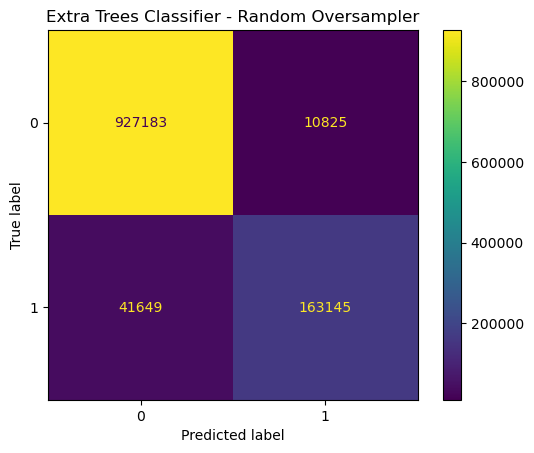

In [20]:
Model = ExtraTreesClassifier(n_jobs=-1)
Model.fit(Classification_Features_Train, Classification_Labels_Train)
FileName = 'ExtraTreesClassifier_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('ExtraTreesClassifier_RandomOversampler.joblib')
Model_Pred = Model.predict(Classification_Features_Test)
# print(confusion_matrix(Classification_Labels_Test, Model_Pred))
print(classification_report(Classification_Labels_Test, Model_Pred))
print(f"Balanced Accuracy (Test Set): {round(balanced_accuracy_score(Classification_Labels_Test, Model_Pred), 3)}")
print(f"F1-Score (Test Set): {round(f1_score(Classification_Labels_Test, Model_Pred), 3)}\n")

Confusion_Matrix = plot_confusion_matrix(Model, Classification_Features_Test, Classification_Labels_Test)
plt.title("Extra Trees Classifier - Random Oversampler")
print(Confusion_Matrix)
#del Model
#del Model_Pred

### SVC (Support Vector Classifier) - Random Oversampler

              precision    recall  f1-score   support

           0       0.96      0.97      0.97    938008
           1       0.87      0.81      0.84    204794

    accuracy                           0.95   1142802
   macro avg       0.92      0.89      0.90   1142802
weighted avg       0.94      0.95      0.94   1142802

Balanced Accuracy (Test Set): 0.894
F1-Score (Test Set): 0.842



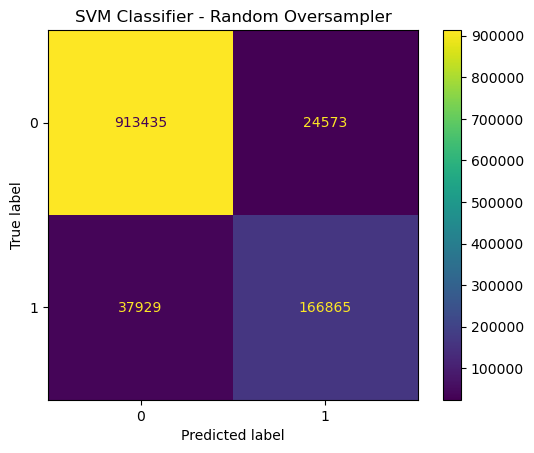

In [21]:
Model = LinearSVC(class_weight='balanced', random_state=123)
Model.fit(Classification_Features_Train, Classification_Labels_Train)
FileName = 'LinearSVC_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('LinearSVC_RandomOversampler.joblib')
Model_Pred = Model.predict(Classification_Features_Test)
# print(confusion_matrix(Classification_Labels_Test, Model_Pred))
print(classification_report(Classification_Labels_Test, Model_Pred))
print(f"Balanced Accuracy (Test Set): {round(balanced_accuracy_score(Classification_Labels_Test, Model_Pred), 3)}")
print(f"F1-Score (Test Set): {round(f1_score(Classification_Labels_Test, Model_Pred), 3)}\n")

Confusion_Matrix = plot_confusion_matrix(Model, Classification_Features_Test, Classification_Labels_Test)
plt.title("SVM Classifier - Random Oversampler")
print(Confusion_Matrix)
#del Model
#del Model_Pred

### Performance Evaluation - Random Oversampler

In [22]:
Performance_DF = pd.DataFrame(columns=["Classifiers", "FPR", "TPR", "AUC"]) 
# FPR: False Positive Rate ; TPR: True Positive Rate ; AUC: Area Under Curve

# Handling Extra Trees Classifier separately due to Memory Constraints
FPR, TPR, _ = roc_curve(Classification_Labels_Test,  Model_Pred)
AUC = roc_auc_score(Classification_Labels_Test, Model_Pred)
# Results
#Performance_DF = Performance_DF.append({"Classifiers": "ExtraTreesClassifier",
#                                        "FPR": FPR, 
#                                        "TPR": TPR, 
#                                        "AUC": AUC}, ignore_index=True)
#del Model
del Model_Pred

Classifiers = ["LogisticRegression", "DecisionTreeClassifier", "GradientBoostingClassifier", "XGBClassifier", "RandomForestClassifier", "ExtraTreesClassifier", "LinearSVC"]
for clf in Classifiers:
    # Load Trained Classifiers
    Model = joblib.load(f"{clf}_RandomOversampler.joblib")
    Model_Pred = Model.predict(Classification_Features_Test)
    FPR, TPR, _ = roc_curve(Classification_Labels_Test,  Model_Pred)
    AUC = roc_auc_score(Classification_Labels_Test, Model_Pred)
    # Record the results
    Performance_DF = Performance_DF.append({"Classifiers": clf,
                                        "FPR": FPR, 
                                        "TPR": TPR, 
                                        "AUC": AUC}, ignore_index=True)
del Model
del Model_Pred

# Classifiers Index
Performance_DF.set_index("Classifiers", inplace=True)

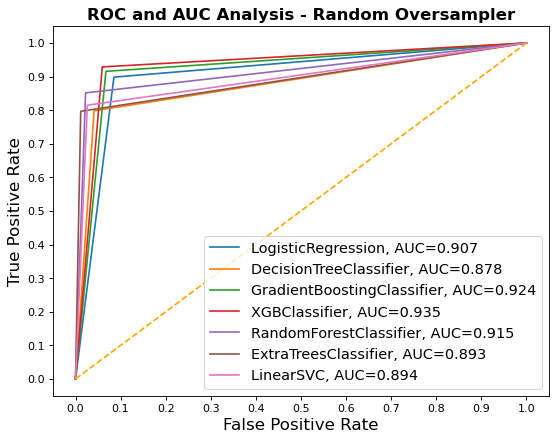

In [23]:
fig = plt.figure(figsize=(8,6), dpi=80)
for clf_name in Performance_DF.index:
    plt.plot(Performance_DF.loc[clf_name]["FPR"], 
             Performance_DF.loc[clf_name]["TPR"], 
             label="{}, AUC={:.3f}".format(clf_name, Performance_DF.loc[clf_name]["AUC"]))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title("ROC and AUC Analysis - Random Oversampler", fontweight="bold", fontsize=15)
plt.legend(prop={"size":13}, loc="lower right")

plt.show()

## Regression
### Features for Regression
ARRIVAL_DELAY is set as the dependent variable. For the independent variable, all the features are used except for ARRIVAL_DELAY, FLIGHT_STATUS, SCHEDULED_ARRIVAL and ARRIVAL_TIME. For both variables, only delayed flights from the dataset are considered (FLIGHT_STATUS == 1).

In [24]:
# Only Delayed Flights are Considered
# Filtering Data for Regression Training and TestingLabels_Train
dataset = dataset[dataset["FLIGHT_STATUS"] == 1]
dataset.reset_index(inplace=True, drop=True)
Labels = np.asarray(dataset["ARRIVAL_DELAY"])
Features = dataset.drop(columns = ['SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'FLIGHT_STATUS', 'ARRIVAL_DELAY'])
Features_Train, Features_Test, Labels_Train, Labels_Test = train_test_split(Features, Labels, test_size=0.20, train_size=0.8, random_state=42)
del Features
del Labels

In [25]:
# Filtering Data for Regression Training and Testing
Regression_Features_Train, Regression_Features_Test = Features_Train, Features_Test
Regression_Labels_Train, Regression_Labels_Test = Labels_Train, Labels_Test

In [26]:
Performance_DF = pd.DataFrame(columns=["Regressors", "MSE", "RMSE", "MAE", "R2"])
def print_metrics(Regression_Labels_Test, Model_Pred, regressor_name, Performance_DF):
    
    MSE = mean_squared_error(Regression_Labels_Test, Model_Pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(Regression_Labels_Test, Model_Pred)
    r2 = r2_score(Regression_Labels_Test, Model_Pred)
    
    print(f"MSE      : {MSE}", end="\n\n")
    print(f"RMSE     : {RMSE}", end="\n\n")
    print(f"MAE      : {MAE}", end="\n\n")
    print(f"R2 Score : {r2}", end="\n\n")
    
    Performance_DF = Performance_DF.append({"Regressors": regressor_name,
                                        "MSE": MSE, 
                                        "RMSE": RMSE,
                                        "MAE": MAE,
                                        "R2": r2}, ignore_index=True)
    return Performance_DF


## Regression Models Training

### Linear Regression - Random Oversampler

In [27]:
Model = LinearRegression(n_jobs=-1)
Model.fit(Regression_Features_Train, Regression_Labels_Train)
FileName = 'LinearRegression_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('LinearRegression_RandomOversampler.joblib')
Model_Pred = Model.predict(Regression_Features_Test)
Performance_DF = print_metrics(Regression_Labels_Test, Model_Pred, "LinearRegression", Performance_DF)
#del Model
#del Model_Pred

MSE      : 136.484804842499

RMSE     : 11.682671134740504

MAE      : 8.533655913392728

R2 Score : 0.9674568905023674



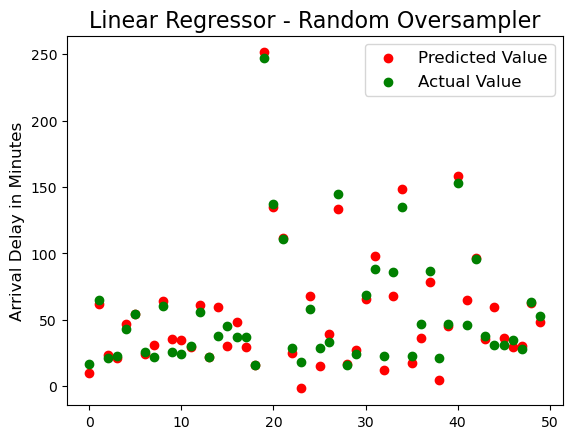

In [28]:
fig,ax1 = plt.subplots()
ax1.scatter(y=Model_Pred[200:250],x=[i for i in range(50)],c='r',label='Predicted Value')
ax1.scatter(y=Regression_Labels_Test[200:250],x=[i for i in range(50)],c='g',label='Actual Value')
ax1.legend(fontsize=12)
ax1.set_ylabel('Arrival Delay in Minutes',fontsize=12)
ax1.set_title('Linear Regressor - Random Oversampler',fontsize=16)
plt.show()
del Model
del Model_Pred

### Decision Tree Regressor - Random Oversampler

In [29]:
Model = DecisionTreeRegressor()
Model.fit(Regression_Features_Train, Regression_Labels_Train)
FileName = 'DecisionTreeRegressor_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('DecisionTreeRegressor_RandomOversampler.joblib')
Model_Pred = Model.predict(Regression_Features_Test)
Performance_DF = print_metrics(Regression_Labels_Test, Model_Pred, "DecisionTreeRegressor", Performance_DF)
#del Model
#del Model_Pred

MSE      : 188.40160723009282

RMSE     : 13.72594649669351

MAE      : 9.69227650219834

R2 Score : 0.9550779726674032



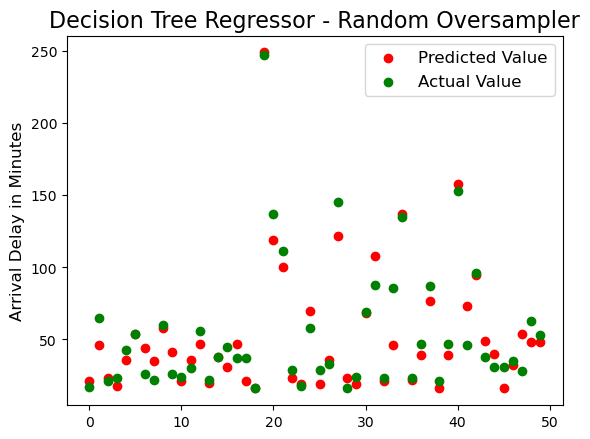

In [30]:
fig,ax2 = plt.subplots()
ax2.scatter(y=Model_Pred[200:250],x=[i for i in range(50)],c='r',label='Predicted Value')
ax2.scatter(y=Regression_Labels_Test[200:250],x=[i for i in range(50)],c='g',label='Actual Value')
ax2.legend(fontsize=12)
ax2.set_ylabel('Arrival Delay in Minutes',fontsize=12)
ax2.set_title('Decision Tree Regressor - Random Oversampler',fontsize=16)
plt.show()
del Model
del Model_Pred

### Gradient Boosting Regressor - Random Oversampler

In [31]:
Model = GradientBoostingRegressor()
Model.fit(Regression_Features_Train, Regression_Labels_Train)
FileName = 'GradientBoostingRegressor_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('GradientBoostingRegressor_RandomOversampler.joblib')
Model_Pred = Model.predict(Regression_Features_Test)
Performance_DF = print_metrics(Regression_Labels_Test, Model_Pred, "GradientBoostingRegressor", Performance_DF)
#del Model
#del Model_Pred

MSE      : 98.5403985995562

RMSE     : 9.926751664041777

MAE      : 7.1364876111970785

R2 Score : 0.9765042637144382



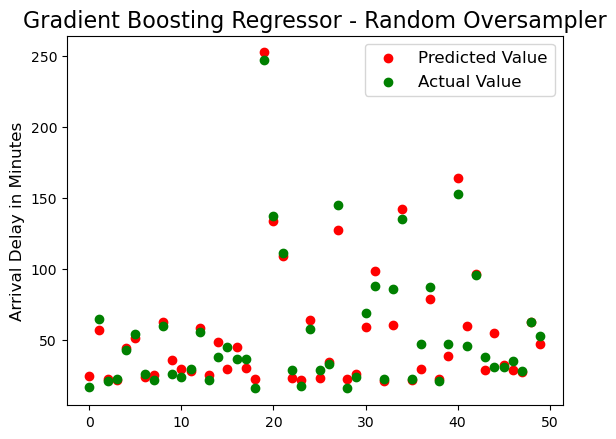

In [32]:
fig,ax3 = plt.subplots()
ax3.scatter(y=Model_Pred[200:250],x=[i for i in range(50)],c='r',label='Predicted Value')
ax3.scatter(y=Regression_Labels_Test[200:250],x=[i for i in range(50)],c='g',label='Actual Value')
ax3.legend(fontsize=12)
ax3.set_ylabel('Arrival Delay in Minutes',fontsize=12)
ax3.set_title('Gradient Boosting Regressor - Random Oversampler',fontsize=16)
plt.show()
del Model
del Model_Pred

### XGBoost Regressor - Random Oversampler

In [33]:
Model = XGBRegressor()
Model.fit(Regression_Features_Train, Regression_Labels_Train)
FileName = 'XGBRegressor_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('XGBRegressor_RandomOversampler.joblib')
Model_Pred = Model.predict(Regression_Features_Test)
Performance_DF = print_metrics(Regression_Labels_Test, Model_Pred, "XGBRegressor", Performance_DF)
#del Model
#del Model_Pred

MSE      : 74.69150978984254

RMSE     : 8.64242499474786

MAE      : 6.138520635186491

R2 Score : 0.9821907355588828



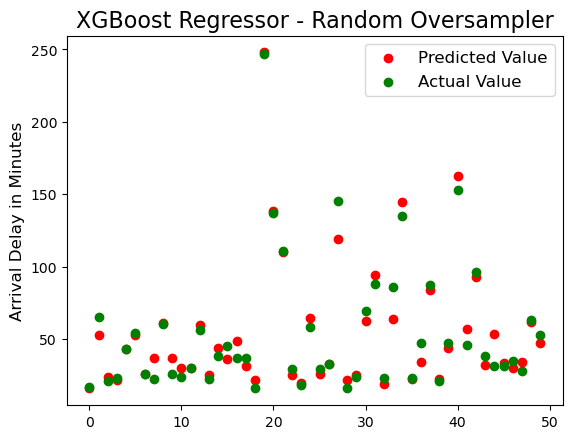

In [34]:
fig,ax4 = plt.subplots()
ax4.scatter(y=Model_Pred[200:250],x=[i for i in range(50)],c='r',label='Predicted Value')
ax4.scatter(y=Regression_Labels_Test[200:250],x=[i for i in range(50)],c='g',label='Actual Value')
ax4.legend(fontsize=12)
ax4.set_ylabel('Arrival Delay in Minutes',fontsize=12)
ax4.set_title('XGBoost Regressor - Random Oversampler',fontsize=16)
plt.show()
del Model
del Model_Pred

### Random Forest Regressor - Random Oversampler

In [35]:
Model = RandomForestRegressor(n_jobs=-1)
Model.fit(Regression_Features_Train, Regression_Labels_Train)
FileName = 'RandomForestRegressor_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('RandomForestRegressor_RandomOversampler.joblib')
Model_Pred = Model.predict(Regression_Features_Test)
Performance_DF = print_metrics(Regression_Labels_Test, Model_Pred, "RandomForestRegressor", Performance_DF)
#del Model
#del Model_Pred

MSE      : 89.3592221880801

RMSE     : 9.453000697560542

MAE      : 6.686725989252562

R2 Score : 0.9786934013962523



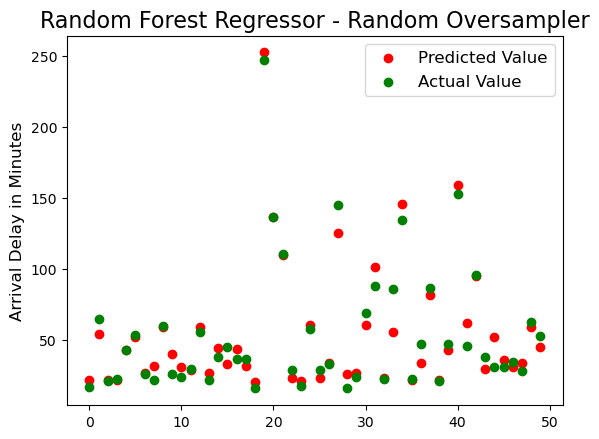

In [36]:
fig,ax5 = plt.subplots()
ax5.scatter(y=Model_Pred[200:250],x=[i for i in range(50)],c='r',label='Predicted Value')
ax5.scatter(y=Regression_Labels_Test[200:250],x=[i for i in range(50)],c='g',label='Actual Value')
ax5.legend(fontsize=12)
ax5.set_ylabel('Arrival Delay in Minutes',fontsize=12)
ax5.set_title('Random Forest Regressor - Random Oversampler',fontsize=16)
plt.show()
del Model
del Model_Pred

### Extra Trees Regressor - Random Oversampler

In [37]:
Model = ExtraTreesRegressor(n_jobs=-1)
Model.fit(Regression_Features_Train, Regression_Labels_Train)
FileName = 'ExtraTreesRegressor_RandomOversampler.joblib'
joblib.dump(Model, FileName)
#Model = joblib.load('ExtraTreesRegressor_RandomOversampler.joblib')
Model_Pred = Model.predict(Regression_Features_Test)
Performance_DF = print_metrics(Regression_Labels_Test, Model_Pred, "ExtraTreesRegressor", Performance_DF)
#del Model
#del Model_Pred

MSE      : 92.2465082784563

RMSE     : 9.604504582666214

MAE      : 6.8275691255495845

R2 Score : 0.9780049638262346



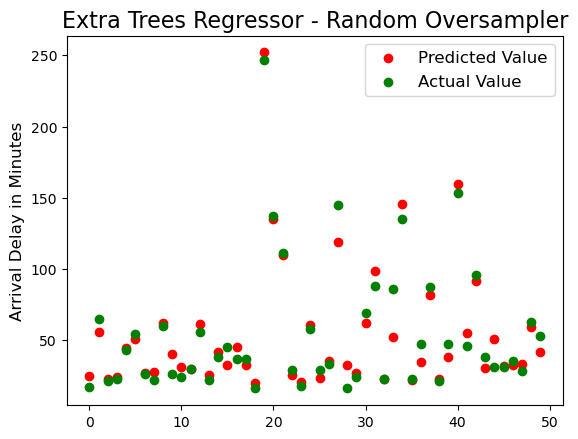

In [38]:
fig,ax6 = plt.subplots()
ax6.scatter(y=Model_Pred[200:250],x=[i for i in range(50)],c='r',label='Predicted Value')
ax6.scatter(y=Regression_Labels_Test[200:250],x=[i for i in range(50)],c='g',label='Actual Value')
ax6.legend(fontsize=12)
ax6.set_ylabel('Arrival Delay in Minutes',fontsize=12)
ax6.set_title('Extra Trees Regressor - Random Oversampler',fontsize=16)
plt.show()
del Model
del Model_Pred